# pycalphad triangluar

Make ternary isotherms with pycalphad. 

The following database can be found at https://doi.org/10.1016/j.jnoncrysol.2016.09.031. It is not linked in this repo because the file is behind a paywall. Nevertheless, changing the database and component names should give you the same plot in any case. 

In [1]:
database_file = '/Users/brandon/Box Sync/databases/literature/Al-Cu-Zr_Zhou.tdb'

Imports and setup of the database

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from pycalphad import Database, ternplot, variables as v
dbf = Database(database_file)
phases = list(dbf.phases.keys())
comps = ['AL','CU','ZR','VA']
conditions = {v.X('ZR'): (0,1,0.008), v.X('AL'): (0,1,0.009), v.P: 101325, v.T: 1373}

/Users/brandon/.virtualenvs/espei/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


/Users/brandon/Projects/pycalphad/pycalphad/core/utils.py:146: RuntimeWarning: divide by zero encountered in log
  pts = -np.log(pts)
/Users/brandon/Projects/pycalphad/pycalphad/core/utils.py:150: RuntimeWarning: invalid value encountered in true_divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.32399999999999995)), ('X_ZR', array(0.176))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.17099999999999999)), ('X_ZR', array(0.656))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.26999999999999996)), ('X_ZR', array(0.632))])


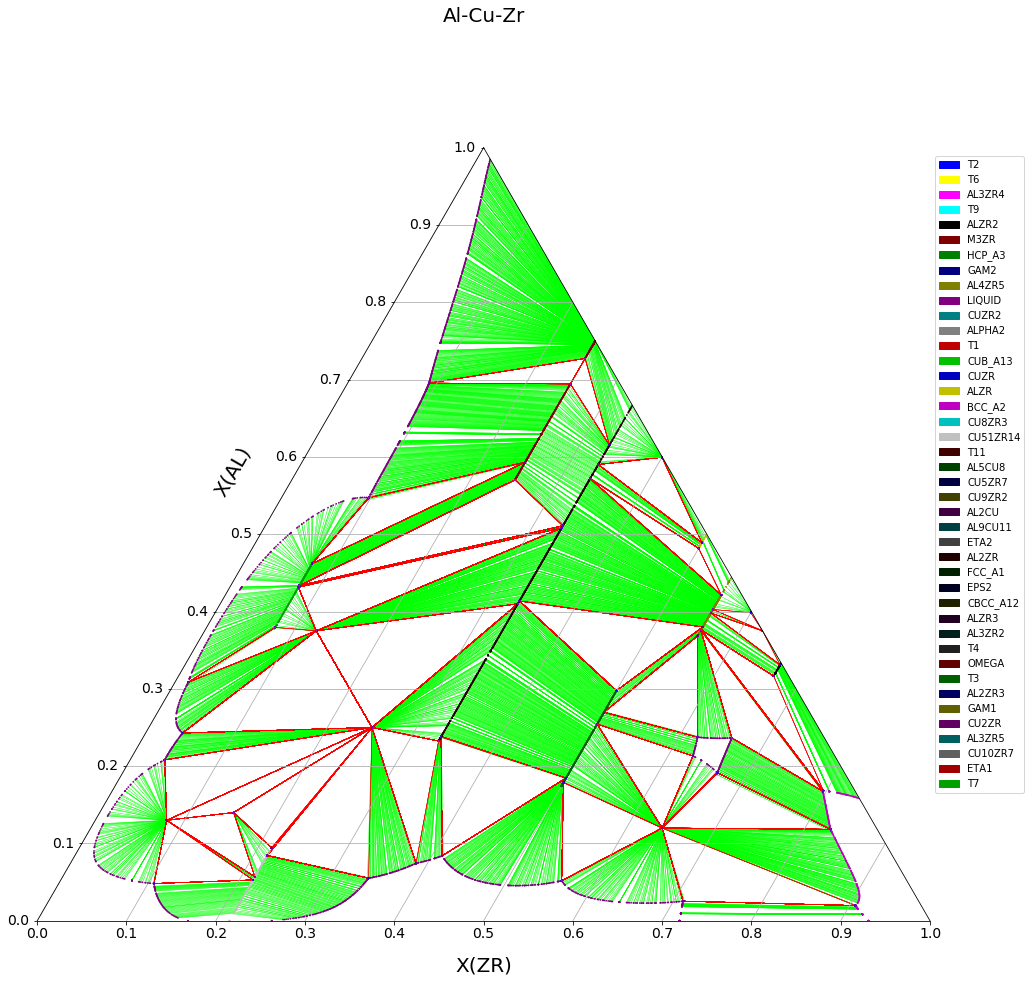

In [3]:
fig = plt.figure(figsize=(20,20))
ternplot(dbf, comps, phases, conditions, x=v.X('ZR'), y=v.X('AL'), eq_kwargs={'calc_opts': {'pdens': 2000}}) 